In [2]:
import astropy.io.fits
import numpy as np
import astropy.table
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ASTR 310 HW 12

### 1) Exoplanet light curve fitting


The Kepler satellite detected planets by observing $\sim$ 150,000 stars over a period of about 9 years and looking for brief drops in the amount of light coming from the stars. These drops can occur when a planet passes in front of its star and partially blocks the star's light output for a time.

**a)** Download the file `kplr010264660-2009131105131_llc.fits` from the course page. This is a FITS file containing Kepler observations of the star 2MASS J19105011+4719589 (Kepler 14), with a transit indicating the presence of the planet Kepler 14b. The FITS file contains a binary table extension HDU that holds the light curve data. Write Python code to read the file and extract the data columns TIME, SAP_FLUX, and SAP_FLUX_ERR. These contain, respectively, the observation time (in units of barycenter-corrected Julian date $-$ 2454833), the stellar flux, and the error in the stellar flux, both measured in electrons s$^{-1}$.

**b)** Select the times between BJD-2454833 = 123.5 and 125.5 days and mask out any NaN values.  (You can use the `numpy.isnan()` function in your Boolean mask expression.)  Plot the flux versus time, including error bars and appropriate axis labels.

[10 pts]

In [3]:
hdulist = astropy.io.fits.open("kplr010264660-2009131105131_llc.fits")
t = astropy.table.Table(hdulist[1].data)
t = t[["TIME", "SAP_FLUX", "SAP_FLUX_ERR"]]

t = t[(t["TIME"] > 123.5) & (t["TIME"] < 125.5)]
mask = ~np.isnan(t["SAP_FLUX"])
t = t[mask]

Text(0.5, 1.0, 'kplr010264660-2009131105131_llc.fits')

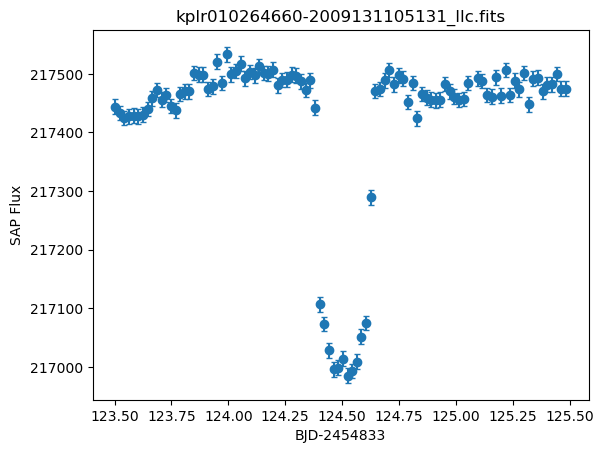

In [4]:
plt.errorbar(x=t["TIME"], y=t["SAP_FLUX"], yerr=t["SAP_FLUX_ERR"], fmt='o', capsize=2)
plt.xlabel("BJD-2454833")
plt.ylabel("SAP Flux")
plt.title("kplr010264660-2009131105131_llc.fits")

**c)**  Use SciPy to fit the light curve using the function

$$ F(t) = 
\begin{cases}
F_0[1 + 4f\frac{t-t_b}{\tau}(\frac{t-t_b}{\tau}-1)] & 0 \leq t-t_b \leq \tau \\
F_0 & \text{otherwise.}
\end{cases}
$$

Here $F_0$ is the uneclipsed stellar flux, $f$ is the fractional light reduction at maximum eclipse, $t_b$  is the beginning time for the eclipse, and $\tau$ is the duration of the eclipse.

* You will probably need to estimate some initial guess values for the parameters; you can do that by inspecting the light curve.
* Plot the best-fit light curve model on top of the data. 
* Report the best-fit values of $F_0$, $f$, $t_b$, and $\tau$, along with their uncertainties.
* Illustrate the uncertainty in the fit parameters as we've been doing: draw 500 random values for the fit parameters, using normal (Gaussian) distributions with means and standard deviations given by the fit parameters and their uncertainties.  Construct 500 new curves from these samples and plot them on your figure.
* Compute the reduced $\chi^2$ value and comment qualitatively on the goodness of fit.

[15 pts]

In [16]:
def lc(t, F0, f, t_b, tau):
    flux = np.full_like(t, F0)

    eclipse_idx = (t >= t_b) & (t <= t_b + tau)
    t_rel = t[eclipse_idx] - t_b 

    flux[eclipse_idx] = F0 * (1 + 4 * f * t_rel / tau * (t_rel / tau - 1))

    return flux

In [6]:
p0, cov = curve_fit(lc, t["TIME"], t["SAP_FLUX"], [217450, 0.002, 124.25, 0.5])

In [7]:
for i in range(len(p0)):
    print(f"{p0[i]} +/- {cov[i,i]}")

217476.3283667312 +/- 12.897867383313997
0.0024510051994884718 +/- 3.92913124420285e-09
124.36034825679646 +/- 1.8068054054694023e-05
0.2952653957459499 +/- 4.347555235128635e-05


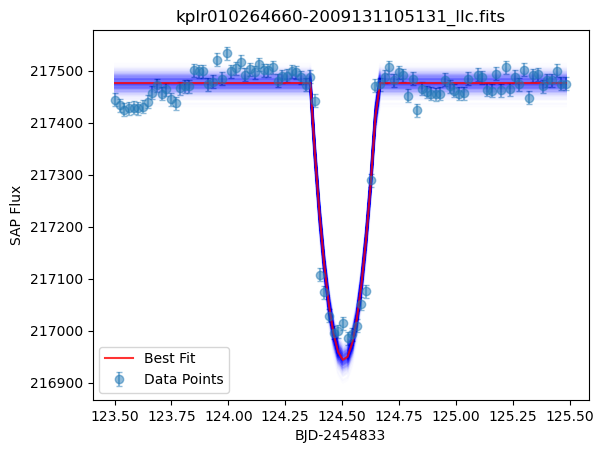

In [8]:
F0 = np.random.normal(loc=p0[0], scale=cov[0,0], size=500)
f = np.random.normal(loc=p0[1], scale=cov[1,1], size=500)
t_b = np.random.normal(loc=p0[2], scale=cov[2,2], size=500)
tau = np.random.normal(loc=p0[3], scale=cov[3,3], size=500)

plt.errorbar(x=t["TIME"], y=t["SAP_FLUX"], yerr=t["SAP_FLUX_ERR"], fmt='o', capsize=2, alpha=0.5, label="Data Points")

for i in range(500):
    y2 = lc(t["TIME"], F0[i], f[i], t_b[i], tau[i])
    plt.plot(t["TIME"], y2, color='b', alpha=0.01)

plt.plot(t["TIME"], lc(t["TIME"], p0[0], p0[1], p0[2], p0[3]), color='red', alpha=0.8, label="Best Fit")
plt.xlabel("BJD-2454833")
plt.ylabel("SAP Flux")
plt.title("kplr010264660-2009131105131_llc.fits")
plt.legend()

In [17]:
residuals = t["SAP_FLUX"] - lc(t["TIME"], *p0)

chi_squared = np.sum((residuals / np.std(t["SAP_FLUX"])) ** 2)

k = len(t["SAP_FLUX"]) - len(p0)
reduced_chi_squared = chi_squared / k

reduced_chi_squared

0.05146483058741106

This low value of chi-squared suggests a poor fit

### 2) Orbital Mechanics

You find yourself adrift (with zero velocity) in a spacecraft a distance $r_0 = 10 R_{Merc}$ from the planet Mercury, which has a mass $M_{Merc} \approx 3.285\times 10^{26}$ g and radius $R_{Merc} \approx 2.440\times 10^{8}$ cm. If you do nothing, you'll crash onto the surface.  However, you do have a bit of fuel remaining, so your task is to figure out how to get yourself into an orbit whose perihermion (closest approach to Mercury) is greater than the radius of Mercury itself.

From orbital mechanics class you know that, if you had a speed $v_0$ oriented at an angle $\theta$ to your radius vector from Mercury, you would find yourself on a Keplerian orbit with perihermion equal to
$$ r_\mathrm{min} = a(1-e),$$
which you can compute as follows.  The specific energy (energy per unit mass) of the orbit is
$$ E/m = \frac{1}{2} v_0^2 - \frac{GM_{Merc}}{r_0} = -\frac{GM_{Merc}}{2a}, $$
which gives the semi-major axis $a$.  The specific angular momentum (per unit mass) is 
$$ L/m = \vec{r}\times \vec{v} = r_0 v_0 \sin \theta.$$
The eccentricity of the orbit comes from 
$$e^2 = 1 + \frac{2EL^2}{G^2 M^2 m^3} = 1 + \frac{2}{G^2M^2}\biggl(\frac{E}{m}\biggr)\biggl(\frac{L}{m}\biggr)^2.$$


You need to briefly fire the engines to put yourself on an orbit such that $r_\mathrm{min} \geq R_{Merc}$ and you don't crash into Mercury. To do that you need to determine $v_0$ and $\theta,$ and to conserve fuel, you need to find the minimum speed that will work.

**a)** Write a Python function to use with `scipy.optimize.root()` to find the necessary $v_0$ to make $r_\mathrm{min} = R_{Merc}$ for a given value of $\theta$.

[8 pts]

In [67]:
R_merc = 2.44e8
M_merc = 3.285e26
G = 6.67e-8
def func(vars, theta):

    v0 = vars[0]

    r0 = 10*R_merc

    spec_E = 0.5*v0**2 - (G * M_merc / r0)
    spec_L = r0*v0*np.sin(theta)

    e = (1 + (2/(G**2 * M_merc**2) * spec_E * spec_L**2))**0.5

    a = -G * M_merc / spec_E / 2

    r_min = a * (1 - e)

    return r_min - R_merc

**b)** For the root finder in the next part, you'll need an initial guess for $v_0$. 
You can obtain a reasonable initial guess as follows.  
First calculate the circular velocity at the surface of Mercury, $v_c = \sqrt{GM_{Merc}/R_{Merc}}.$ Choose $\theta = 0.5$ radian and calculate $r_\mathrm{min}$ for a range of $v_0$ values from 0 to 5 times that circular speed.  Plot $r_\mathrm{min}-R_{Merc}$ vs $v_0$ and use the plot to estimate a reasonable starting guess value for $v_0.$

[7 pts]

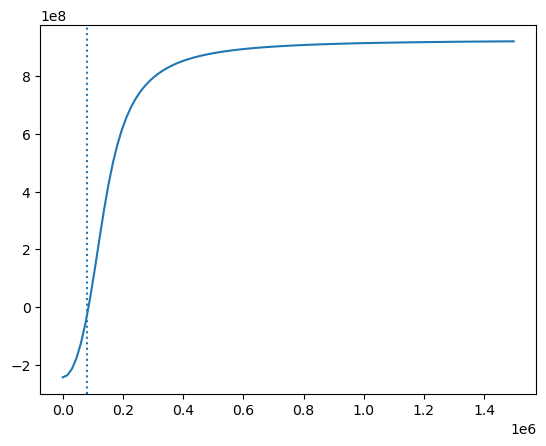

In [68]:
Vc = (G * M_merc / R_merc)**0.5

v0 = np.linspace(0, 5*Vc, 100)

plt.plot(v0, func([v0], 0.5))
plt.axvline(80000, ls='dotted')

**c)** Set up an array of 1000 $\theta$  values between 0 and $2\pi$. For each value, use the `root` function to find the minimum $v_0$ to avoid a crash. 

Plot the $v_0$ values versus $\theta$, for those cases in which the root finder was successful -- some  values will not admit a solution. Remember to use appropriate axis labels. 

**d)** Report the $\theta$ value that allowed for the smallest $v_0$ and that $v_0$ value in km/s.

[10 pts]

In [79]:
from scipy.optimize import root
thetas = np.linspace(0, 2*np.pi, 10000)

solns = []
for angle in thetas:
    solns.append(root(func, [80000], args=(angle,)).x)

np.min(solns)

func([np.min(solns)], thetas[np.argmin(solns)])


3.8743019104003906e-07

Text(0, 0.5, 'Angle')

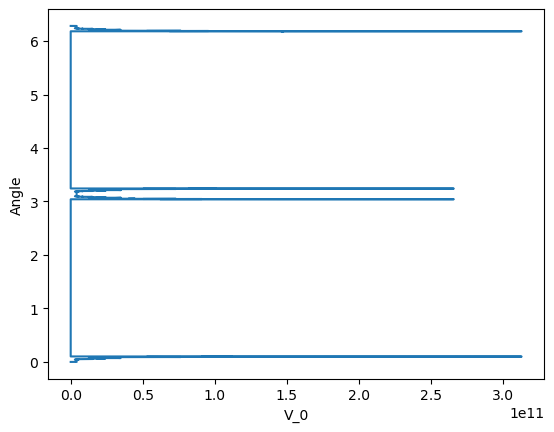

In [81]:
plt.plot(solns, thetas)
plt.xlabel("V_0")
plt.ylabel("Angle")